<a href="https://colab.research.google.com/github/yuuki-kusumoto/kusumoto/blob/master/multi_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

     |████████████████████████████████| 2.3MB 6.9MB/s 
     |████████████████████████████████| 901kB 29.5MB/s 
     |████████████████████████████████| 3.3MB 38.3MB/s 


In [2]:
!apt install aptitude swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp

In [3]:
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y

git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)
xz-utils is already installed at the requested version (5.2.2-1.3)
git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)
xz-utils is already installed at the requested version (5.2.2-1.3)
The following NEW packages will be installed:
  file libmagic-mgc{a} libmagic1{a} libmecab-dev libmecab2{a} mecab mecab-ipadic{a} mecab-ipadic-utf8 mecab-jumandic{a} mecab-jumandic-utf8{a} mecab-utils{a} 
0 packages upgraded, 11 newly installed, 0 to remove and 39 not upgraded.
Need to get 29.3 MB of archives. After unpacking 282 MB will be used.
Get: 1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2

In [4]:
pip install MeCab

     |████████████████████████████████| 71kB 3.9MB/s 
  Created wheel for MeCab: filename=mecab-0.996.3-cp37-cp37m-linux_x86_64.whl size=141798 sha256=6b618eb4d3f36a7d1482b76df1fb019bfdd63a71b8a67e80d61d75765cf73323
  Stored in directory: /root/.cache/pip/wheels/8f/95/18/2c71c144b3c41ba34f532aa8b6531d1d93980a71db8b3d200b
Successfully built MeCab


In [5]:
pip install mecab-python3

     |████████████████████████████████| 491kB 7.0MB/s 


In [6]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [7]:
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[install-mecab-ipadic-NEologd] :     egrep => ok
[install-mecab-ipadic-NEologd] :     mecab => ok
[install-mecab-ipadic-NEologd] :     mecab-config => ok
[install-mecab-ipadic-NEologd] :     make => ok
[install-mecab-ipadic-NEologd] :     curl => ok
[install-mecab-ipadic-NEologd] :     sed => ok
[install-mecab-ipadic-NEologd] :     cat => ok
[install-mecab-ipadic-NEologd] :     diff => ok
[install-mecab-ipadic-NEologd] :     tar => ok
[install-mecab-ipadic-NEologd] :     unxz => ok
[install-mecab-ipadic-NEologd] :     xargs => ok
[install-mecab-ipadic-NEologd] :     grep => ok
[install-mecab-ipadic-NEologd] :     iconv => ok
[install-mecab-ipadic-NEologd] :     patch => ok
[install-mecab-ipadi

In [8]:
import subprocess

cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')

In [9]:
pip install neologdn

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for neologdn: filename=neologdn-0.5.1-cp37-cp37m-linux_x86_64.whl size=172949 sha256=5bf23969fea16da5f4d009f06bd3e34a0f6eef43fefda7bd969f3382b70c7d37
  Stored in directory: /root/.cache/pip/wheels/e0/b8/03/6c4210244645d18770a3314cbdd853879322f42d249cb2b4b0
Successfully built neologdn


In [10]:
pip install ipadic

     |████████████████████████████████| 13.4MB 221kB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-cp37-none-any.whl size=13556725 sha256=b45a43aeb766bed32c15330b59e39e692003ddbd6756c1f090402cc5e0330a8c
  Stored in directory: /root/.cache/pip/wheels/ff/00/d1/0c094a0ce58a77199a0c5801f0ecf510c80f0ecbec27f07d2c
Successfully built ipadic


In [11]:
pip install mecab-python3

In [12]:
pip install unidic-lite

     |████████████████████████████████| 47.4MB 61kB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-cp37-none-any.whl size=47658838 sha256=28c462031673666f7bd05622be3681d9440abfad281da4882665f5d285935237
  Stored in directory: /root/.cache/pip/wheels/20/48/8d/b66d8361a27f58f41ec86640e4fd2640de0403a6367511eab7
Successfully built unidic-lite


In [13]:
# MeCabとtransformersを用意する
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
# 以下で報告があるようにmecab-python3のバージョンを0.996.5にしないとtokezerで落ちる
# https://stackoverflow.com/questions/62860717/huggingface-for-japanese-tokenizer
!pip install mecab-python3==0.996.5
!pip install unidic-lite # これないとMeCab実行時にエラーで落ちる
!pip install transformers

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already instal

In [14]:
pip install "transformers==2.5.1"

     |████████████████████████████████| 501kB 5.1MB/s 
     |████████████████████████████████| 1.2MB 10.2MB/s 
     |████████████████████████████████| 5.6MB 25.1MB/s 
     |████████████████████████████████| 133kB 28.0MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 7.6MB 35.3MB/s 
ERROR: botocore 1.20.96 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Found existing installation: transformers 4.6.1
    Uninstalling transformers-4.6.1:
      Successfully uninstalled transformers-4.6.1


In [15]:
import torch
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer

In [16]:
! curl http://www.cl.ecei.tohoku.ac.jp/resources/sent_lex/pn.csv.m3.120408.trim > pn.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  676k  100  676k    0     0   465k      0  0:00:01  0:00:01 --:--:--  465k


In [17]:
import transformers
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer

model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

# model_nameはここから取得(cf. https://huggingface.co/transformers/pretrained_models.html)
model_name = "cl-tohoku/bert-base-japanese"
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

CSVデータの読み込み

In [18]:
import pandas as pd

df1 = pd.read_csv('travel.csv', index_col=0)
df1.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,text,breakfast_po,breakfast_ne,dinner_po,dinnerne,bath_po,bath_ne,servis_po,service_ne,state_po,state_ne,facility_po,facility_ne,room_po,room_ne
0,3月30日宿泊。,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,今回は函館観光というよりも、こちらの別邸宿泊が目的だったので、早めにチェックインしてホテルラ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,低層階のシャワーブースのみのお部屋でしたが、広々とした部屋のうえ、ソファーやダイニングテーブ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
3,洗面化粧台の電球が切れていましたが、すぐに対応して頂きました。,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,また、洗面所に手拭きタオルが用意されていなかったので、トイレにあったタオルを移動して手拭きと...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [19]:
df1.columns=['text','breakfast_po',	'breakfast_ne',	'dinner_po',	'dinner_ne',	'bath_po',	'bath_ne',	'servis_po',	'service_ne',	'state_po',	'state_ne',	'facility_po',	'facility_ne'	,'room_po', 'room_ne']

In [20]:
df = df1.fillna(0)
df.head()

,text,breakfast_po,breakfast_ne,dinner_po,dinner_ne,bath_po,bath_ne,servis_po,service_ne,state_po,state_ne,facility_po,facility_ne,room_po,room_ne
0,3月30日宿泊。,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,今回は函館観光というよりも、こちらの別邸宿泊が目的だったので、早めにチェックインしてホテルラ...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,低層階のシャワーブースのみのお部屋でしたが、広々とした部屋のうえ、ソファーやダイニングテーブ...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,洗面化粧台の電球が切れていましたが、すぐに対応して頂きました。,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,また、洗面所に手拭きタオルが用意されていなかったので、トイレにあったタオルを移動して手拭きと...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
print(df.dtypes)

text             object
breakfast_po     object
breakfast_ne    float64
dinner_po       float64
dinner_ne       float64
bath_po         float64
bath_ne         float64
servis_po       float64
service_ne      float64
state_po        float64
state_ne        float64
facility_po     float64
facility_ne     float64
room_po         float64
room_ne         float64
dtype: object


データフレーム内の値をfloat型からobject型に変換

In [22]:
df_int2 = df[['breakfast_ne',	'dinner_po',	'dinner_ne',	'bath_po',	'bath_ne',	'servis_po',	'service_ne',	'state_po',	'state_ne',	'facility_po',	'facility_ne'	,'room_po', 'room_ne']].astype(int)
print(df_int2.dtypes)

breakfast_ne    int64
dinner_po       int64
dinner_ne       int64
bath_po         int64
bath_ne         int64
servis_po       int64
service_ne      int64
state_po        int64
state_ne        int64
facility_po     int64
facility_ne     int64
room_po         int64
room_ne         int64
dtype: object


In [23]:
df_int2 = df[['breakfast_ne',	'dinner_po',	'dinner_ne',	'bath_po',	'bath_ne',	'servis_po',	'service_ne',	'state_po',	'state_ne',	'facility_po',	'facility_ne'	,'room_po', 'room_ne']].astype(int)
print(df_int2.dtypes)

breakfast_ne    int64
dinner_po       int64
dinner_ne       int64
bath_po         int64
bath_ne         int64
servis_po       int64
service_ne      int64
state_po        int64
state_ne        int64
facility_po     int64
facility_ne     int64
room_po         int64
room_ne         int64
dtype: object


In [24]:
df_object = df_int2.astype(object)
print(df_object.dtypes)

breakfast_ne    object
dinner_po       object
dinner_ne       object
bath_po         object
bath_ne         object
servis_po       object
service_ne      object
state_po        object
state_ne        object
facility_po     object
facility_ne     object
room_po         object
room_ne         object
dtype: object


In [25]:
df_int1 = df[['text','breakfast_po']]
print(df_int1.dtypes)

text            object
breakfast_po    object
dtype: object


In [26]:
#データフレームを結合させる
df_concat = pd.concat([df_int1, df_object], axis =1)

In [27]:
df = df_concat

In [28]:
df2 = df[['text','dinner_po',	'dinner_ne',	'bath_po',	'bath_ne',	'servis_po',	'service_ne',	'state_po',	'state_ne',	'facility_po',	'facility_ne'	,'room_po', 'room_ne']]
df2 = df2.sample(frac=1, random_state=127).reset_index(drop=True)
df2.shape

(76624, 13)

In [29]:
# tsvファイルで保存する

# 全体の2割の文章数
len_0_2 = len(df2) // 5

# 前から2割をテストデータとする
df2[:len_0_2].to_csv("./test.tsv", sep='\t', index=False, header=None)
print(df2[:len_0_2].shape)

# 前2割からを訓練&検証データとする
df2[len_0_2:].to_csv("./train.tsv", sep='\t', index=False, header=None)
print(df2[len_0_2:].shape)

(15324, 13)
(61300, 13)


In [30]:
# 乱数シードの固定

import os
import random
import numpy as np
import torch

SEED_VALUE = 1234
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)  

In [31]:
from torchtext.legacy import data
import torch
import torchtext  # torchtextを使用

In [32]:
def tokenizer_512(input_text):
    """torchtextのtokenizerとして扱えるように、512単語のpytorchでのencodeを定義。ここで[0]を指定し忘れないように"""
    return tokenizer.encode(input_text, max_length=512, return_tensors='pt')[0]


TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenizer_512, use_vocab=False, lower=False,include_lengths=True, batch_first=True, fix_length=512, pad_token=0)
# 注意：tokenize=tokenizer.encodeと、.encodeをつけます。padding[PAD]のindexが0なので、0を指定します。

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL2 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL3 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL4 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL5 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL6 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL7 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL8 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL9 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL10 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL11 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL12 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

In [33]:
import torch
import torchtext
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer


# 日本語BERTの分かち書き用tokenizerを宣言
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

In [34]:
import transformers
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer

model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

# model_nameはここから取得(cf. https://huggingface.co/transformers/pretrained_models.html)
model_name = "cl-tohoku/bert-base-japanese"
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

In [35]:
# 各tsvファイルを読み込み、分かち書きをしてdatasetに
# train_eval：61300個、test：15324個
dataset_train_eval, dataset_test = torchtext.legacy.data.TabularDataset.splits(
    path='.', train='train.tsv', test='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label', LABEL), ('Label2', LABEL2), ('Label3', LABEL3),  ('Label4', LABEL4), ('Label5', LABEL5), ('Label6', LABEL6), ('Label7', LABEL7), ('Label8', LABEL8), ('Label9', LABEL9), ('Label10', LABEL10), ('Label11', LABEL11), ('Label12', LABEL12)])

In [36]:
# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：61300個、test：15324個

dataset_train, dataset_eval = dataset_train_eval.split(
    split_ratio = 1 - 15324 / 61300, random_state=random.seed(1234))

# datasetの長さを確認してみる
print(dataset_train.__len__())
print(dataset_eval.__len__())
print(dataset_test.__len__())

# datasetの中身を確認してみる
item = next(iter(dataset_train))
print(item.Text)
print("長さ：", len(item.Text))  

45976
15324
15324
tensor([    2,  8567, 28457, 28457, 28452,  1049, 28455,  2239,     8,     3])
長さ： 10


In [37]:
print('訓練データの数', len(dataset_train_eval))
print('1つ目の訓練データkazu', vars(dataset_train_eval[10]))
print(vars(dataset_train_eval[0])['Label'])
print(len(vars(dataset_train_eval[0])))

# datasetの中身を文章に戻し、確認

print(tokenizer.convert_ids_to_tokens(item.Text.tolist()))  # 文章

訓練データの数 61300
1つ目の訓練データkazu {'Text': tensor([    2,   107, 16131,     5,   968,    13,    52,  8601,     5, 28447,
        28506,     6, 12988, 28446, 28454, 11214, 28447, 28458,     6,   129,
         1341,    40,  3438,   372,   995,  7253,    49,   761,  2997,   118,
        28450,     6,  2482,  1513, 12580, 28504, 28456,  1273,   609, 28456,
         1234, 20431, 11214, 28447,     8,     3]), 'Label': '0', 'Label2': '0', 'Label3': '0', 'Label4': '0', 'Label5': '0', 'Label6': '0', 'Label7': '0', 'Label8': '0', 'Label9': '1', 'Label10': '0', 'Label11': '1', 'Label12': '0'}
0
13
['[CLS]', 'とても', '##い', '##い', '##と', '##ころ', '##で', '##した', '。', '[SEP]']


327


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


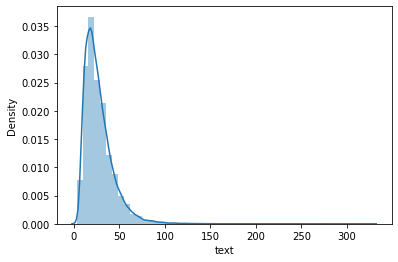

In [39]:
#@title
# 日本語BERTで扱える文章の長さは512
import seaborn as sns
title_length = df['text'].map(tokenizer.encode).map(len)
print(max(title_length))

sns.distplot(title_length)

In [40]:
# DataLoaderの作成

batch_size = 12


dl_train = torchtext.legacy.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)

dl_eval = torchtext.legacy.data.Iterator(
    dataset_eval, batch_size=batch_size, train=False, sort=False)

dl_test = torchtext.legacy.data.Iterator(
    dataset_test, batch_size=batch_size, train=False, sort=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": dl_train, "val": dl_eval}

In [41]:
# DataLoaderの動作確認 

batch = next(iter(dl_test))
print(batch)
print(batch.Text[0].shape)
print(batch.Label2.shape)


[torchtext.legacy.data.batch.Batch of size 12]
	[.Text]:('[torch.LongTensor of size 12x512]', '[torch.LongTensor of size 12]')
	[.Label]:[torch.LongTensor of size 12]
	[.Label2]:[torch.LongTensor of size 12]
	[.Label3]:[torch.LongTensor of size 12]
	[.Label4]:[torch.LongTensor of size 12]
	[.Label5]:[torch.LongTensor of size 12]
	[.Label6]:[torch.LongTensor of size 12]
	[.Label7]:[torch.LongTensor of size 12]
	[.Label8]:[torch.LongTensor of size 12]
	[.Label9]:[torch.LongTensor of size 12]
	[.Label10]:[torch.LongTensor of size 12]
	[.Label11]:[torch.LongTensor of size 12]
	[.Label12]:[torch.LongTensor of size 12]
torch.Size([12, 512])
torch.Size([12])


In [42]:
from torch import nn


class BertForReview(nn.Module):
    '''BERTモデルにレビュー文の2クラスを判定する部分をつなげたモデル'''

    def __init__(self):
        super(BertForReview, self).__init__()

        # BERTモジュール
        self.bert = model  # 日本語学習済みのBERTモデル

        # headにポジネガ予測を追加
        # 入力はBERTの出力特徴量の次元768、出力は12クラス
        self.cls = nn.Linear(in_features=768, out_features=12)

        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)

    def forward(self, input_ids):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        result = self.bert(input_ids)  # reult は、sequence_output, pooled_output

        # sequence_outputの先頭の単語ベクトルを抜き出す
        vec_0 = result[0]  # 最初の0がsequence_outputを示す
        vec_0 = vec_0[:, 0, :]  # 全バッチ。先頭0番目の単語の全768要素
        vec_0 = vec_0.view(-1, 768)  # sizeを[batch_size, hidden_size]に変換
        output = self.cls(vec_0)  # 全結合層

        return output

In [43]:
#モデル構築
net = BertForReview()

# 訓練モードに設定
net.train()

print('ネットワーク設定完了')

ネットワーク設定完了


In [44]:
# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for param in net.parameters():
    param.requires_grad = False

# 2. BertLayerモジュールの最後を勾配計算ありに変更
for param in net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for param in net.cls.parameters():
    param.requires_grad = True

In [45]:
# 最適化手法の設定
import torch.optim as optim

# BERTの元の部分はファインチューニング
optimizer = optim.Adam([
    {'params': net.bert.encoder.layer[-1].parameters(), 'lr': 6e-6},
    {'params': net.cls.parameters(), 'lr': 1e-4}
])

# 損失関数
criterion = nn.BCEWithLogitsLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

In [46]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # ミニバッチのサイズ
    batch_size = dataloaders_dict["train"].batch_size

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            iteration = 1

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書型変数

                # GPUが使えるならGPUにデータを送る
                inputs = batch.Text[0].to(device)  # 文章
                labels = batch.Label.to(device)  # ラベル
                labels2 = batch.Label2.to(device)
                labels3 = batch.Label3.to(device)
                labels4 = batch.Label4.to(device)
                labels5 = batch.Label5.to(device)
                labels6 = batch.Label6.to(device)
                labels7 = batch.Label7.to(device)
                labels8 = batch.Label8.to(device)
                labels9 = batch.Label9.to(device)
                labels10 = batch.Label10.to(device)
                labels11 = batch.Label11.to(device)
                labels12 = batch.Label12.to(device)
                pa = torch.stack([labels, labels2, labels3, labels4, labels5,labels6,labels7,labels8,labels9,labels10, labels11, labels12], dim = 1)

                pa = torch.tensor(pa, dtype=torch.float32)


                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # BERTに入力
                    outputs = net(inputs)
##############################################################################################################################################
###################　　　　　　　ここまではおそらくあってる　　　　　　　###################################################################################
################################################################################################################################################

                    loss = criterion(outputs, pa)  # 損失を計算

#第二引数の1は行。axis = 1と同じ。
#torch.maxは最大値（テンソル）とその要素位置の２つを返しますが、その最大値を_で受けとっています。　ただ、最大値は不要なので適当な名前(_)の変数としています。
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時は逆誤差伝搬
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
#10イテレーションごとの計算で、割るときの分母にはバッチサイズに12をかけておく
                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            acc = (torch.sum(preds == pa.data)
                                   ).double()/(12*batch_size)
                            print('イテレーション {} || Loss: {:.4f} || 10iter. || 本イテレーションの正解率：{}'.format(
                                iteration, loss.item(),  acc))

                    iteration += 1

                    # 損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == pa.data)
                    

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))

    return net

In [ ]:
# 学習・検証を実行する。
num_epochs = 5

net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)

In [ ]:
from tqdm import tqdm

# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0

a = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

for batch in tqdm(dl_test):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = batch.Text[0].to(device)  # 文章
    labels = batch.Label.to(device)  # ラベル
    labels2 = batch.Label2.to(device)
    labels3 = batch.Label3.to(device)
    labels4 = batch.Label4.to(device)
    labels5 = batch.Label5.to(device)
    labels6 = batch.Label6.to(device)
    labels7 = batch.Label7.to(device)
    labels8 = batch.Label8.to(device)
    labels9 = batch.Label9.to(device)
    labels10 = batch.Label10.to(device)
    labels11 = batch.Label11.to(device)
    labels12 = batch.Label12.to(device)
    pa = torch.stack([labels, labels2, labels3, labels4, labels5,labels6,labels7,labels8,labels9,labels10, labels11, labels12], dim = 1)

    pa = torch.tensor(pa, dtype=torch.float32)



    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # BertForReviewに入力
        outputs = net_trained(inputs)

        loss = criterion(outputs, pa)  # 損失を計算
        _, preds = torch.max(outputs, 1)  # ラベルを予測
        epoch_corrects += torch.sum(preds == pa.data)  # 正解数の合計を更新
        
        cm = confusion_matrix(pa.cpu().numpy(), preds.cpu().numpy()) # 混同行列(numpy.ndarray)の取得
        print("コンフュージョンマトリックス")
        a = cm + a
        print(a)


# 正解率
epoch_acc = epoch_corrects.double() / len(dl_test.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_acc))